# Credit scoring for retail portfolio

## Content

- Data
    - Upload and visualize data
    - Plot some graphs and KPIs in time
    
    
- Fitting a model
    - Logistic regression
    - Generalized Additive Models (GAMs)
    - Decision tree
    - Gradient boosting
 
 
- Interpreting a model
    - Regression coefficients
    - Partial dependence plots
    - Rules from tree
    - Feature importance
    - SHAP values
 
 
- Validating a model
    - Precision, recall, F1
    - ROC and PR curve
    - Score distribution and optimal threshold
    - Probability calibration
    
    
- Financial impact
    - Profitability curve
    - Model risk and degradation


- Additional topics
    - AutoML
    - More interpretability
    
    
## References
- [Lending Club Data](https://www.kaggle.com/pavlofesenko/minimizing-risks-for-loan-investments)
- https://www.kaggle.com/faressayah/lending-club-loan-defaulters-prediction
- https://learn.datacamp.com/courses/credit-risk-modeling-in-python

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

/tmp/ipykernel_29745/4105761827.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data

In [3]:
data_description = pd.read_excel('lending_club_main_features.xlsx', usecols=['LoanStatNew', 'Description'])

data_description

,LoanStatNew,Description
0,loan_amnt,The listed amount of the loan applied for by t...
1,term,The number of payments on the loan. Values are...
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if th...
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when ap...
7,emp_length,Employment length in years. Possible values ar...
8,home_ownership,The home ownership status provided by the borr...
9,annual_inc,The self-reported annual income provided by th...


Load data

In [4]:
X = pd.read_pickle('lc_data_processed.pkl')

X['issue_d'] = pd.to_datetime(X['issue_d'], format='%b-%Y', errors='coerce')

print(X.shape)
X.head()

(395219, 80)


,loan_amnt,term,int_rate,installment,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,36,11.44,329.48,117000.0,2015-01-01,0,26.24,1990,16.0,0,36369.0,41.8,25.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,8000.0,36,11.99,265.68,65000.0,2015-01-01,0,22.05,2004,17.0,0,20131.0,53.3,27.0,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,15600.0,36,10.49,506.97,43057.0,2015-01-01,0,12.79,2007,13.0,0,11987.0,92.2,26.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
3,7200.0,36,6.49,220.65,54000.0,2014-11-01,0,2.60,2006,6.0,0,5472.0,21.5,13.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,24375.0,60,17.27,609.33,55000.0,2013-04-01,1,33.95,1999,13.0,0,24584.0,69.8,43.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395219 entries, 0 to 396029
Data columns (total 80 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   loan_amnt                            395219 non-null  float64       
 1   term                                 395219 non-null  int64         
 2   int_rate                             395219 non-null  float64       
 3   installment                          395219 non-null  float64       
 4   annual_inc                           395219 non-null  float64       
 5   issue_d                              395219 non-null  datetime64[ns]
 6   loan_status                          395219 non-null  int64         
 7   dti                                  395219 non-null  float64       
 8   earliest_cr_line                     395219 non-null  object        
 9   open_acc                             395219 non-null  float64       
 10  p

### Check target distribution and its evolution in time 

In [6]:
target = 'loan_status'

In [7]:
X[target].value_counts(normalize=True)

loan_status
0    0.803848
1    0.196152
Name: proportion, dtype: float64

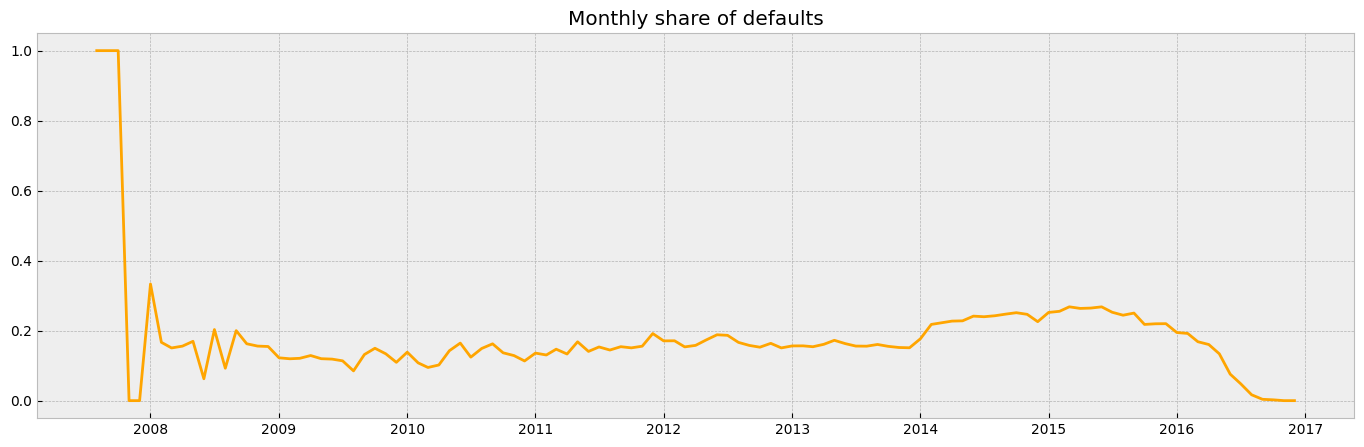

In [8]:
fig = plt.figure()
fig.set_size_inches(17,5)

plt.plot(X.groupby('issue_d')[target].mean(), linewidth=2, color="orange")

plt.title('Monthly share of defaults')

plt.show()

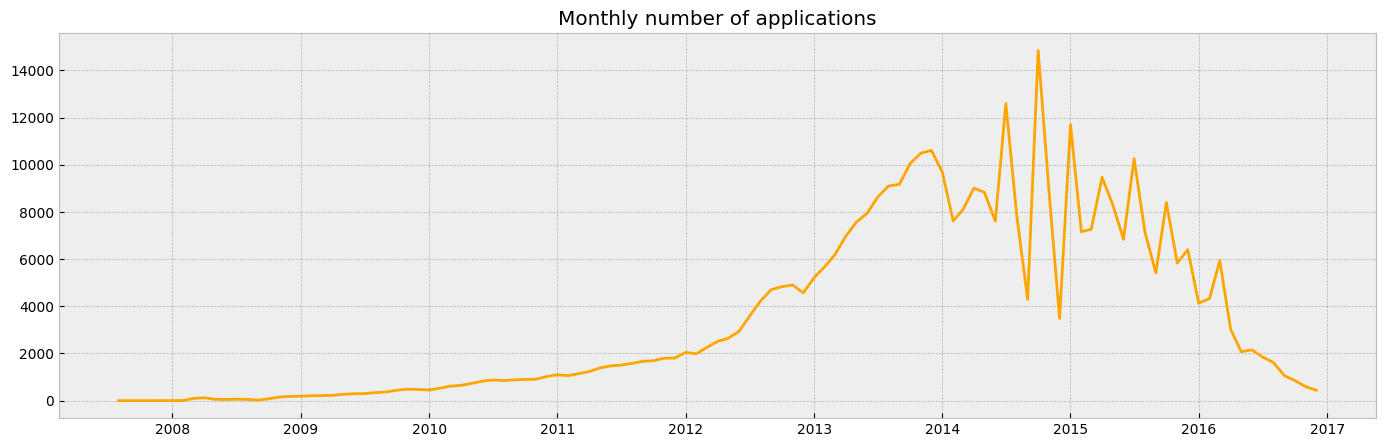

In [9]:
fig = plt.figure()
fig.set_size_inches(17,5)

plt.plot(X.groupby('issue_d')[target].count(), linewidth=2, color="orange")

plt.title('Monthly number of applications')

plt.show()

### Filter only valid years

Let's drop some early dates since the data is unstable there

In [10]:
idx = ((X['issue_d'] >= '2012-01-01') & (X['issue_d'] < '2016-01-01'))

X = X.loc[idx]

X = X.fillna(0)

# Models training and interpretability

## Final preparations

### Filter only needed columns

In [11]:
columns_to_remove = [target]
columns_to_remove += [col for col in X.columns if X[col].dtype in ['O', 'datetime64[ns]']]
columns_to_remove += [col for col in X.columns if 'zip_code' in col]
columns_to_remove += [col for col in X.columns if X[col].dtype == 'uint8']

feature_columns = [col for col in X.columns if col not in columns_to_remove]

len(feature_columns)

13

### Train-test split

We can do a split by time or by applications

In [12]:
last_train_date = '2014-01-01'

idx_train = (X['issue_d'] < last_train_date)

X_train = X.loc[idx_train, feature_columns].copy()
y_train = X.loc[idx_train, target].copy()

X_test = X.loc[~idx_train, feature_columns].copy()
y_test = X.loc[~idx_train, target].copy()

print(X_train.shape)
print(X_test.shape)

(138766, 13)
(197011, 13)


In [13]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X[feature_columns], X[target], test_size=0.3, random_state=42, stratify=X[target])

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

## Logistic regression

### Fit

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(C=0.57,penalty='l1', solver='liblinear').fit(X_train, y_train)

forecast_lr = model_lr.predict_proba(X_test)[:,1]

print('AUC score: {:.2f}'.format(roc_auc_score(y_test, forecast_lr)))

AUC score: 0.70


### Regression coefficients

In [15]:
coefs = pd.DataFrame(
    model_lr.coef_[0, :],
    columns=['Coefficients'], index=feature_columns
)

coefs['Coefficients_abs'] = np.abs(coefs['Coefficients'])

coefs = coefs.sort_values(by='Coefficients_abs', ascending=False)
coefs = coefs.reset_index()

coefs.head()

,index,Coefficients,Coefficients_abs
0,int_rate,0.102304,0.102304
1,mort_acc,-0.066456,0.066456
2,pub_rec,-0.056334,0.056334
3,term,0.032063,0.032063
4,open_acc,0.022499,0.022499


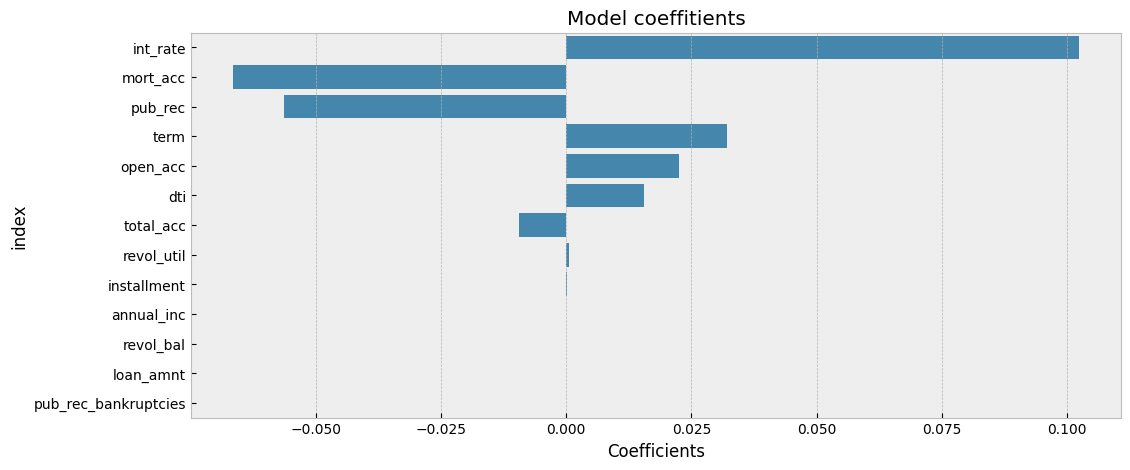

In [16]:
plt.figure(figsize=(12,5))
plt.title('Model coeffitients')
sns.barplot(x='Coefficients', y='index', data=coefs.iloc[:20, :])
plt.show()

## GAMs

https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Introduction

In [17]:
%pip install pygam 

Note: you may need to restart the kernel to use updated packages.


In [18]:
from pygam import LogisticGAM, s, f

gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6)).fit(X_train, y_train)

forecast_gam = gam.predict_proba(X_test.values)
forecast_gam[np.isnan(forecast_gam)] = 0.5

print('AUC score: {:.2f}'.format(roc_auc_score(y_test, forecast_gam)))

AUC score: 0.70


In [19]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     81.9069
Link Function:                        LogitLink Log Likelihood:                                -55767.5694
Number of Samples:                       138766 AIC:                                           111698.9526
                                                AICc:                                          111699.0529
                                                UBRE:                                               2.8054
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0845
Feature Function                  Lam

NameError: name 'XX' is not defined

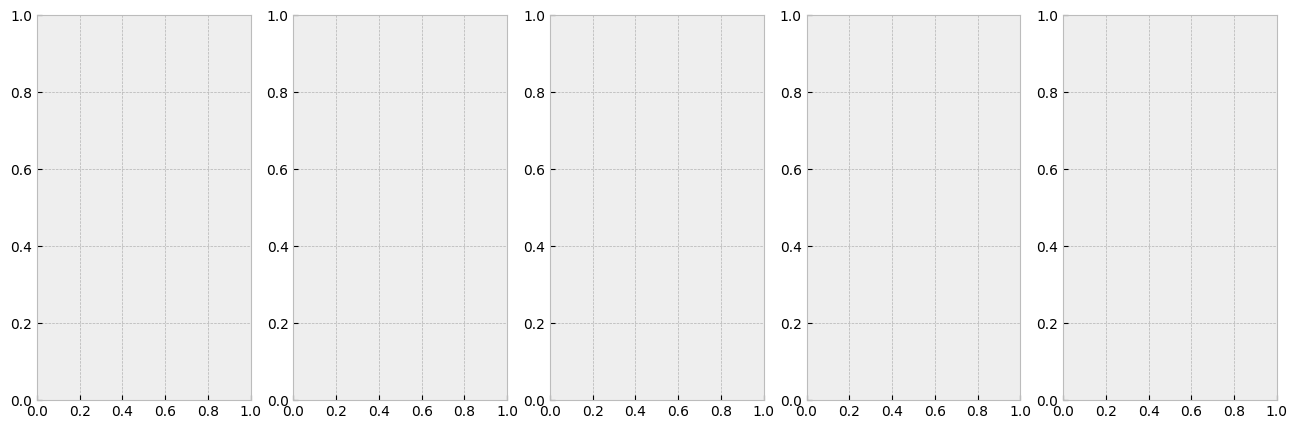

In [20]:
fig, axs = plt.subplots(1,5, figsize=(16,5));

titles = X_train.columns

for i, ax in enumerate(axs):
    
    

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

NameError: name 'XX' is not defined

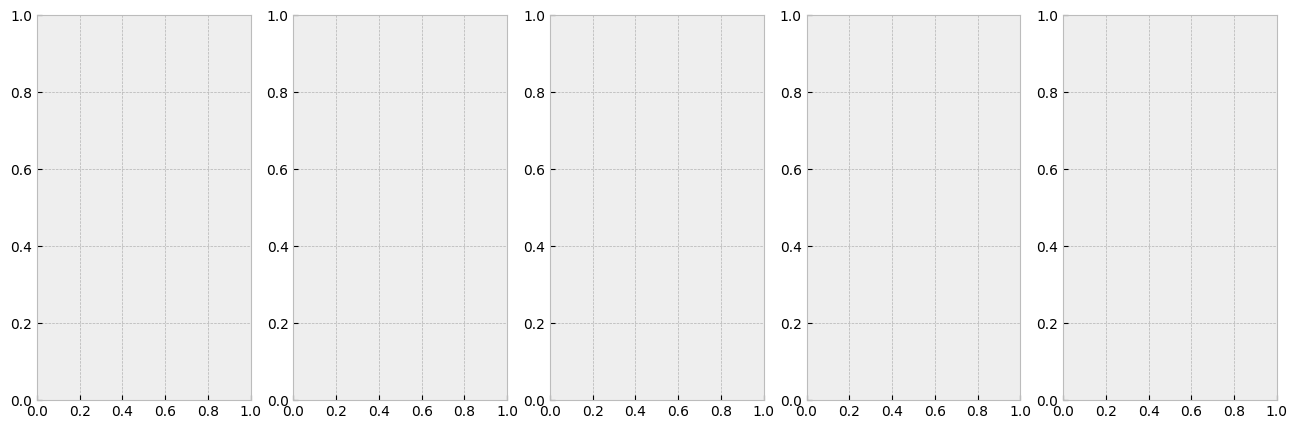

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(16,5));

titles = X_train.columns

for i, ax in enumerate(axs):
    
    pass

    ax.plot(XX[:, i+5], pdep)
    ax.plot(XX[:, i+5], confi, c='r', ls='--')
    ax.set_title(titles[i+5]);

## Decision tree

### Fit

In [21]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(max_depth=6, criterion='gini').fit(X_train, y_train)

forecast_tree = model_tree.predict_proba(X_test)[:,1]

print('AUC score: {:.1f}'.format(roc_auc_score(y_test, forecast_tree)))

AUC score: 0.7


### Rules from a tree

[Text(0.5, 0.9, 'term <= 48.0\ngini = 0.268\nsamples = 138766\nvalue = [116622, 22144]'),
 Text(0.25, 0.7, 'int_rate <= 13.985\ngini = 0.22\nsamples = 115291\nvalue = [100808.0, 14483.0]'),
 Text(0.125, 0.5, 'int_rate <= 9.735\ngini = 0.159\nsamples = 66696\nvalue = [60898, 5798]'),
 Text(0.0625, 0.3, 'annual_inc <= 44760.0\ngini = 0.107\nsamples = 25117\nvalue = [23694, 1423]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'annual_inc <= 50390.0\ngini = 0.188\nsamples = 41579\nvalue = [37204, 4375]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'annual_inc <= 60947.5\ngini = 0.294\nsamples = 48595\nvalue = [39910, 8685]'),
 Text(0.3125, 0.3, 'int_rate <= 16.22\ngini = 0.321\nsamples = 28421\nvalue = [22707, 5714]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'int_rate <= 17.565\ngini = 0.251\nsamples = 20174\nvalue = [17203.0, 2971.0]'

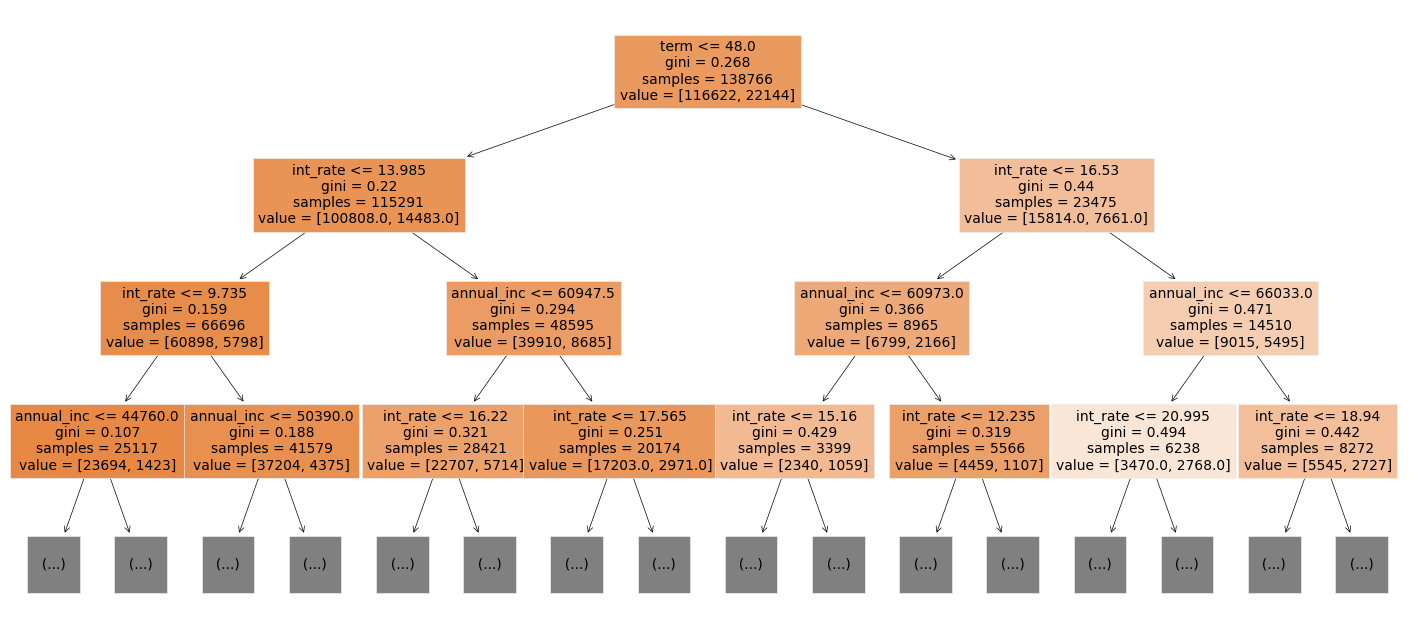

In [24]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18,8))

plot_tree(model_tree, max_depth=3, filled=True, fontsize=10, feature_names=X.columns)

## Gradient boosting

### Fit

In [121]:
import lightgbm as lgb

lgbtrain = lgb.Dataset(data=X_train, label=y_train)
# lgbtest = lgb.Dataset(data=X_test, label=y_test)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.10, 
    
   'feature_fraction': 0.75,
   'bagging_fraction': 0.75, 
   'bagging_freq': 1,
    
    'max_depth': 3,
    
    'nthread': -1,
   'bagging_seed': 42, 
  }

# model_lgb = lgb.train(train_set=lgbtrain, params = lgb_params, num_boost_round=50)
model_lgb = lgb.LGBMClassifier().fit(X_train, y_train)
forecast_boosting = model_lgb.predict_proba(X_test)[:, 0]
print('AUC score: {:.2f}'.format(roc_auc_score(y_test, forecast_boosting)))

[LightGBM] [Info] Number of positive: 22144, number of negative: 116622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 138766, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159578 -> initscore=-1.661371
[LightGBM] [Info] Start training from score -1.661371
AUC score: 0.30


### Variable importance

In [26]:
variable_importance = pd.DataFrame(sorted(zip(model_lgb.feature_importance(importance_type='gain'), feature_columns), reverse=True))

variable_importance.columns = ['gain', 'feature']

variable_importance.head(10)

,gain,feature
0,20990.169141,int_rate
1,12381.003475,term
2,5251.340014,annual_inc
3,1593.358457,dti
4,1449.616323,loan_amnt
5,652.276142,installment
6,351.445101,revol_bal
7,282.958706,open_acc
8,222.464309,mort_acc
9,170.670418,total_acc


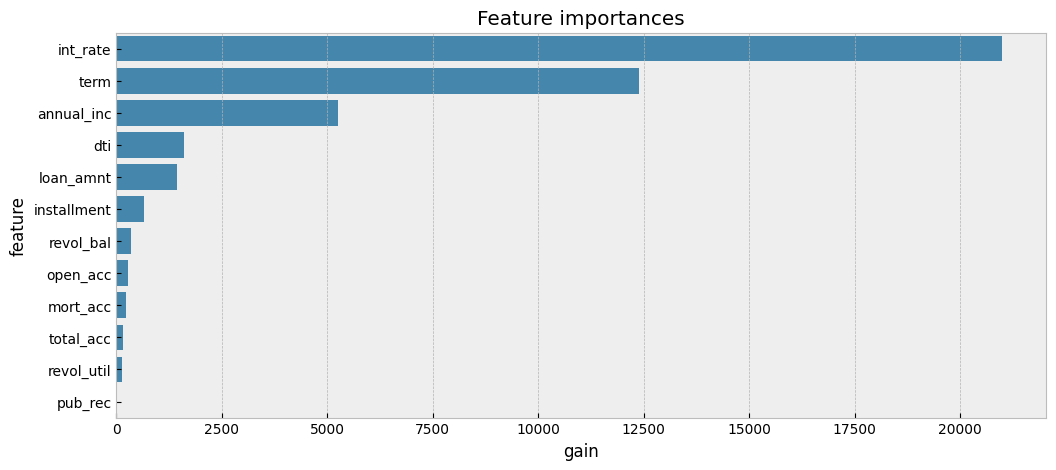

In [27]:
plt.figure(figsize=(12,5))
plt.title('Feature importances')
sns.barplot(x='gain', y='feature', data=variable_importance.iloc[:12, :])
plt.show()

### SHAP values

https://habr.com/ru/articles/428213/

In [28]:
!pip install shap

In [29]:
import shap

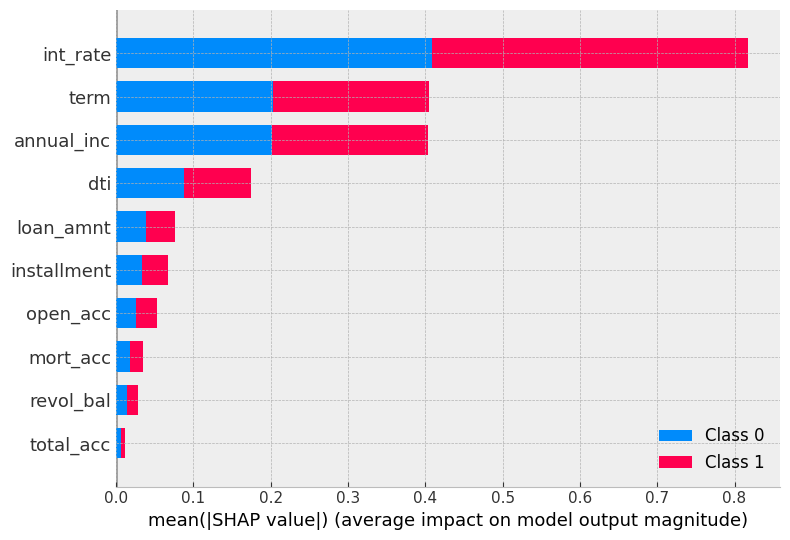

In [30]:
import shap

size_for_shap = 10**4
x_sample = X_train.sample(size_for_shap)

shap_values = shap.TreeExplainer(model_lgb).shap_values(x_sample)

shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)

(10000, 13)
None


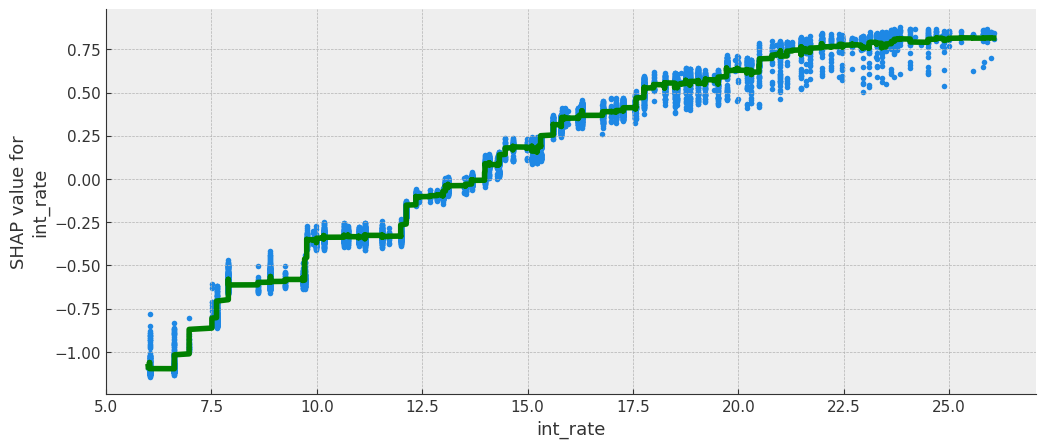

In [31]:
from scipy.ndimage.filters import gaussian_filter1d

variable_selected = 'int_rate'
idx = np.where(np.array(x_sample.columns) == variable_selected)[0][0]

aux_dt = pd.DataFrame({
    'variable_value': x_sample[variable_selected].values,
    'Shap': shap_values[1][:, idx]
})

print(print(shap_values[1].shape))

aux_dt = aux_dt.sort_values(by='variable_value')

# find ysmoothed as gaussian_filter1d for Shap with sigma 10

ysmoothed = gaussian_filter1d(aux_dt['Shap'], sigma=10, mode='nearest')

fig, ax = plt.subplots(figsize=(12,5))

# plot shap.dependence_plot
ax.plot(aux_dt['variable_value'], ysmoothed, 'g-', linewidth=4)
shap.dependence_plot(variable_selected, shap_values[1], x_sample, ax=ax, interaction_index=None)

# ax.plot(aux_dt['variable_value'], ysmoothed, 'g-', linewidth=4)

ax.set_title("{} plot".format(variable_selected))
ax.set_ylabel("Score contribution for the \n {} feature".format(variable_selected))

plt.show()

# Model performance

In [100]:
d = {
    'Logistic regression': forecast_lr,
    'Decision tree': forecast_tree,
    'Boosting': forecast_boosting,
}

## Confusion matrix

In [101]:
from sklearn.metrics import confusion_matrix

for model in d.keys():
    
    print('\n',model)
    
    # get confusion matrix for every model with threshold = 0.5
    n = confusion_matrix(y_test, d[model] >= 0.5)
    print(n)


 Logistic regression
[[148280   1513]
 [ 45105   2113]]

 Decision tree
[[149274    519]
 [ 46468    750]]

 Boosting
[[148629   1164]
 [ 45532   1686]]


## Precision, recall, f1-score for 0.5 threshold

In [102]:
from sklearn.metrics import classification_report

for model in d.keys():

    print('\n',model)
    
    # get classification report for every model with threshold = 0.5
    c = classification_report(y_test, d[model] >= 0.5)
    print(c)


 Logistic regression
              precision    recall  f1-score   support

           0       0.77      0.99      0.86    149793
           1       0.58      0.04      0.08     47218

    accuracy                           0.76    197011
   macro avg       0.67      0.52      0.47    197011
weighted avg       0.72      0.76      0.68    197011


 Decision tree
              precision    recall  f1-score   support

           0       0.76      1.00      0.86    149793
           1       0.59      0.02      0.03     47218

    accuracy                           0.76    197011
   macro avg       0.68      0.51      0.45    197011
weighted avg       0.72      0.76      0.66    197011


 Boosting
              precision    recall  f1-score   support

           0       0.77      0.99      0.86    149793
           1       0.59      0.04      0.07     47218

    accuracy                           0.76    197011
   macro avg       0.68      0.51      0.47    197011
weighted avg       0.72  

## ROC and PR curves

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


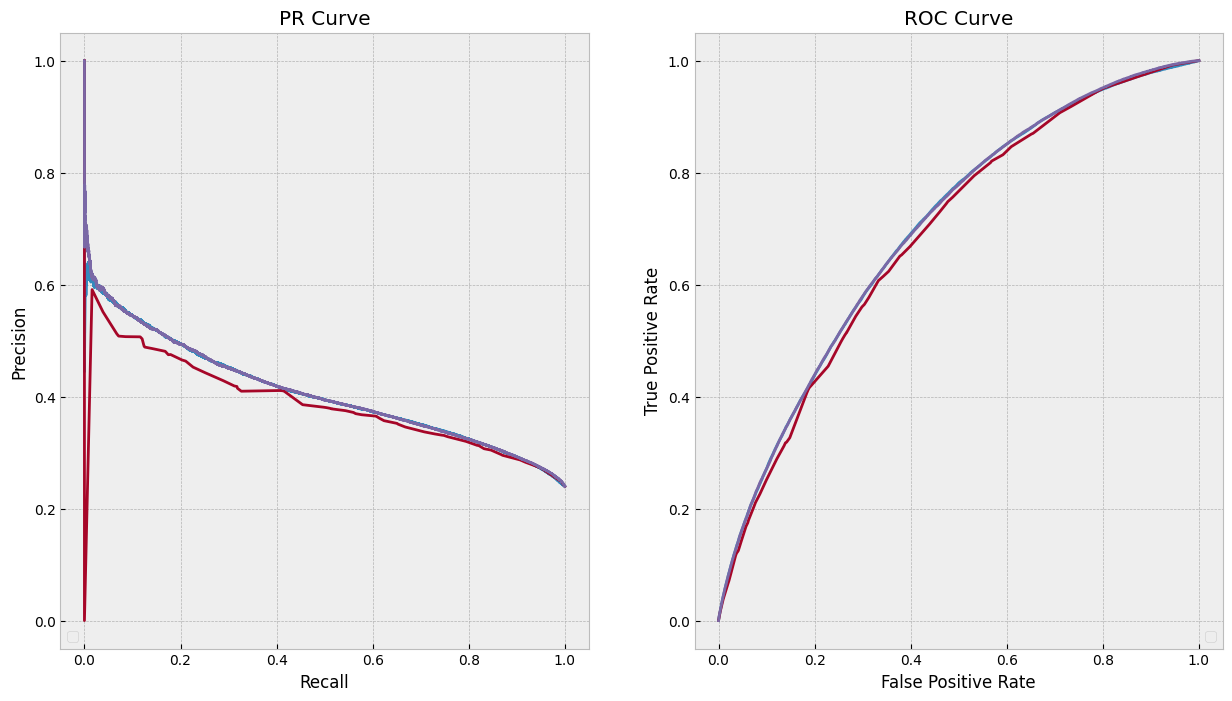

In [103]:
from sklearn.metrics import precision_recall_curve, roc_curve
import seaborn as sns

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
i = 0  
for model in d.keys():
    
    scores = d[model]
    
    # plot precision-recall and ROC AUC curves
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ax1.plot(recall, precision)
    # sns.lineplot(x=recall, y=precision, ax=ax1)
    fpr, tpr, _ = roc_curve(y_test, scores)
    ax2.plot(fpr, tpr)
    # sns.lineplot(x=fpr, y=tpr, ax=ax2)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower right')
                                          
plt.show()

## Precision, recall, f1-score curves

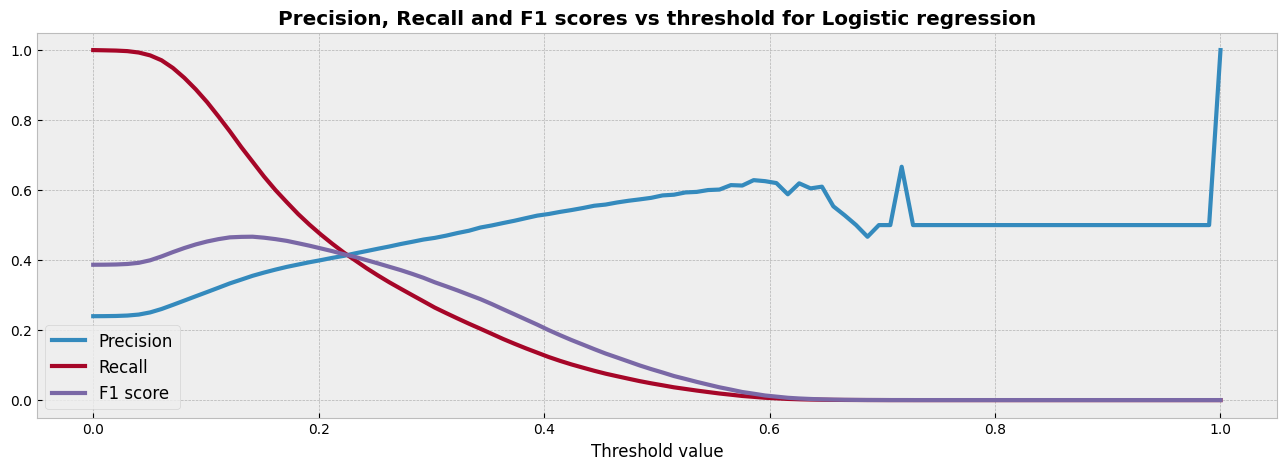

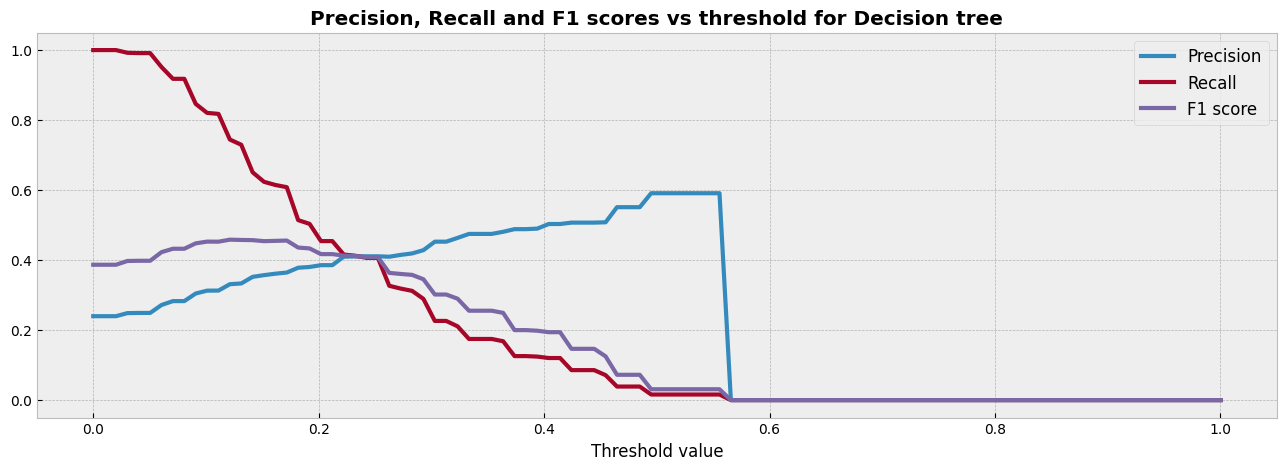

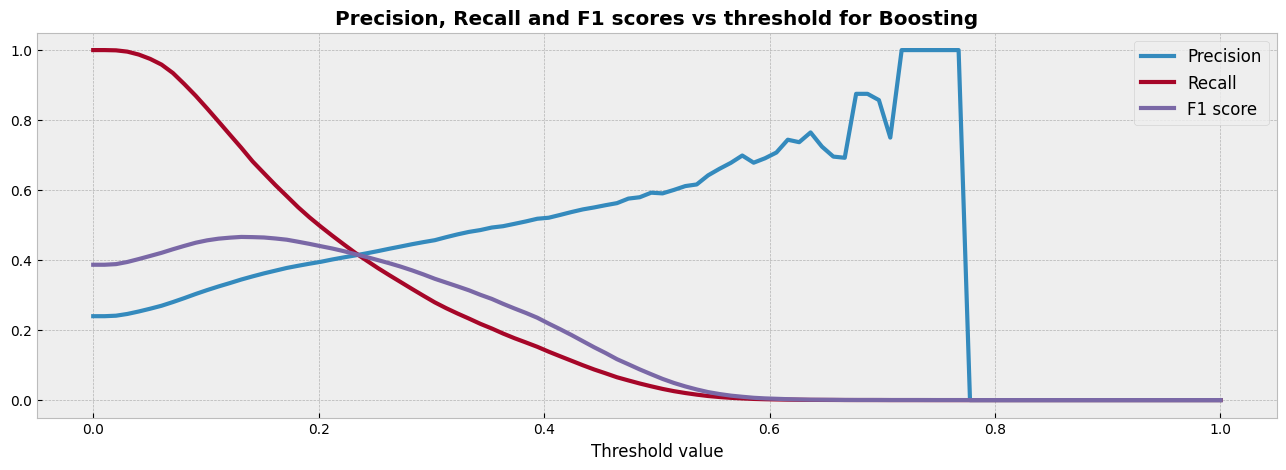

In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score

for model in d.keys():
    
    scores = d[model]

    tr = np.linspace(0, 1, 100)

    p = np.zeros_like(tr)
    r = np.zeros_like(tr)
    f = np.zeros_like(tr)

    for k, x in enumerate(tr):
#         plot precision, recall and f1 scores for every threshold  for every model
        positive_real = y_test == 1
        positive_model = (scores >= x) == 1
        TP = (positive_model & positive_real).sum()
        FP = (positive_model & ~(positive_real)).sum()
        FN = (~(positive_model) & positive_real).sum()
        
        
        if TP + FP: p[k] = TP / (TP + FP)
        if TP + FN: r[k] = TP / (TP + FN)
        if p[k] + r[k]: f[k] = 2*p[k]*r[k]/(p[k] + r[k])
        
        
        
        
    fig = plt.figure(figsize=(16, 5))

    plt.plot(tr, p, linewidth=3)
    plt.plot(tr, r, linewidth=3)
    plt.plot(tr, f, linewidth=3)

    plt.title("Precision, Recall and F1 scores vs threshold for {}".format(model), weight="bold")

    plt.xlabel("Threshold value")

    plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)

    plt.show()

## Score in time

In [80]:
X['predictions_boosting'] = model_lgb.predict(X[feature_columns])

# calculate score values in dynamics
auc_score_in_time = dict()
dates = sorted(X['issue_d'].unique().date)
# print(dates)
X['normal_date']=X['issue_d'].apply(lambda x: x.date())
for date in dates:
    sub_X = X[X['normal_date'] == date]
    # display(sub_X)
    auc_score_in_time[date] = (roc_auc_score(sub_X[target], sub_X['predictions_boosting']))
    
auc_score_in_time = pd.Series(auc_score_in_time)


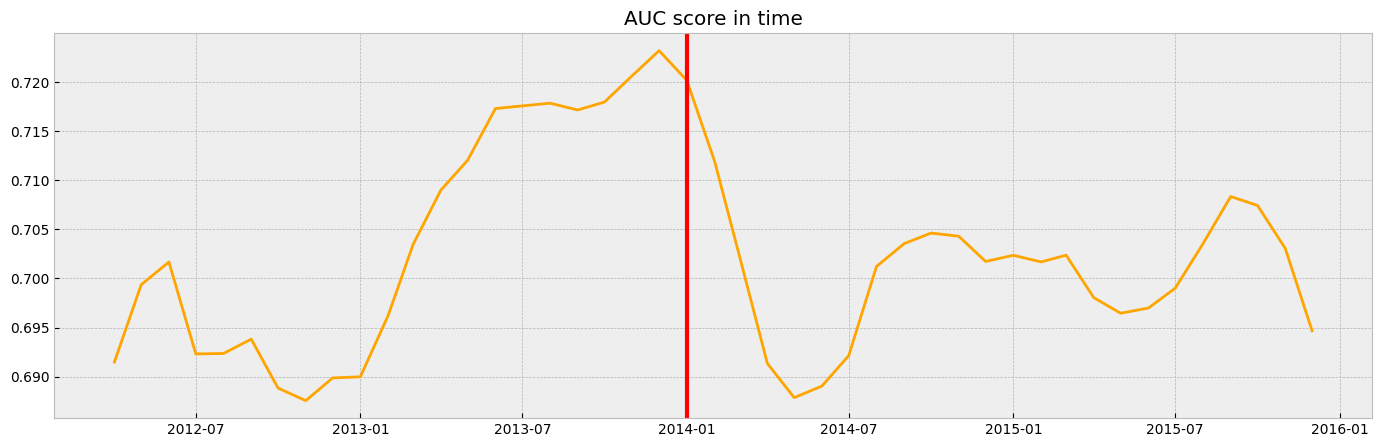

In [82]:
fig = plt.figure()
fig.set_size_inches(17,5)

plt.plot(auc_score_in_time.rolling(4).mean(), linewidth=2, color="orange")

plt.axvline(pd.to_datetime(last_train_date), color='red', linewidth=3)

plt.title('AUC score in time')

plt.show()

## Score distribution and optimal threshold

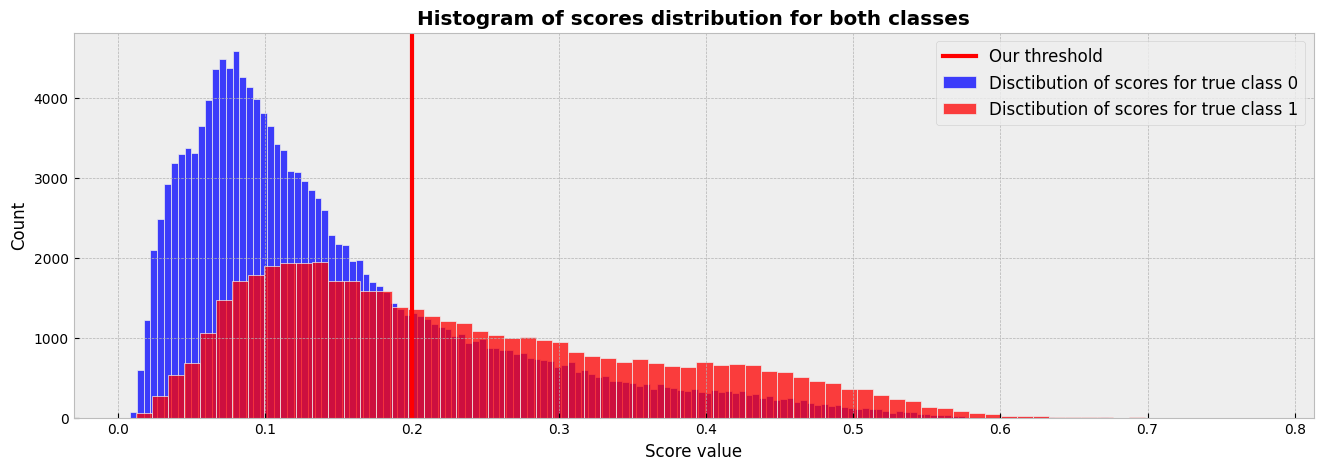

In [122]:
# 'Boosting' 'Logistic regression'
scores = d['Boosting']

fig = plt.figure(figsize=(16, 5))

# plot distribution of scores for class 0 and for class 1
class0 = y_test==0
sns.histplot(x=scores[class0], color='blue')
sns.histplot(x=scores[~class0], color='red')
plt.axvline(0.2, color='red', linewidth=3)

plt.title("Histogram of scores distribution for both classes", weight="bold")

plt.xlabel("Score value")

plt.legend([
    'Our threshold',
    'Disctibution of scores for true class 0',
    'Disctibution of scores for true class 1'], 
    fontsize=12
)

plt.show()

## Probability calibration

model: Logistic regression: 5, 5
model: Decision tree: 4, 4
model: Boosting: 4, 4


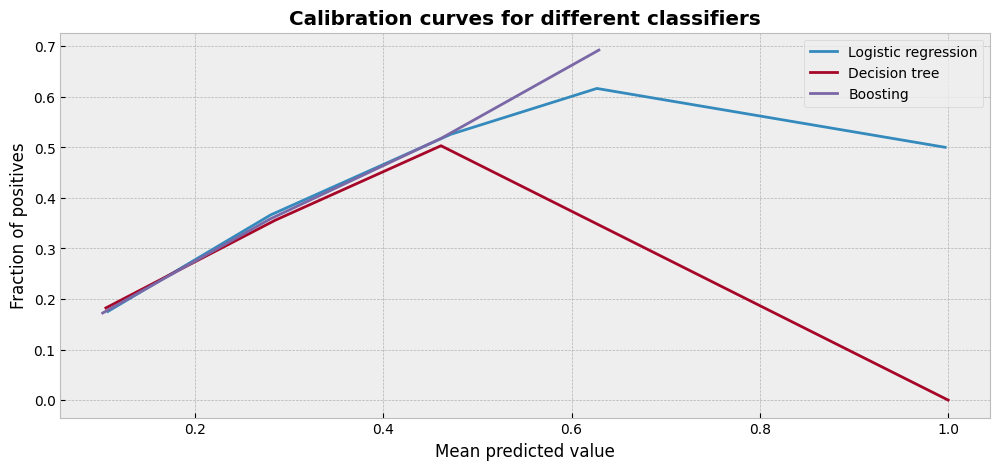

In [119]:
from sklearn.calibration import calibration_curve

# plot calibration curves for every model

fig = plt.figure(figsize=(12, 5))
smth = dict()
for model in d.keys():
    prob_true, prob_pred = calibration_curve(y_test, d[model])
    print(f"model: {model}: {len(prob_pred)}, {len(prob_true)}")
    plt.plot(prob_pred, prob_true)
    smth[model] = prob_pred

plt.legend(d.keys())

plt.title("Calibration curves for different classifiers", weight="bold")

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")

plt.show()

In [120]:
for key, el in smth.items():
    print(key, el)

Logistic regression [0.10761829 0.28044926 0.47173796 0.62694194 0.99682854]
Decision tree [0.10549124 0.28514215 0.46138171 1.        ]
Boosting [0.10208791 0.28019021 0.46172469 0.62907132]


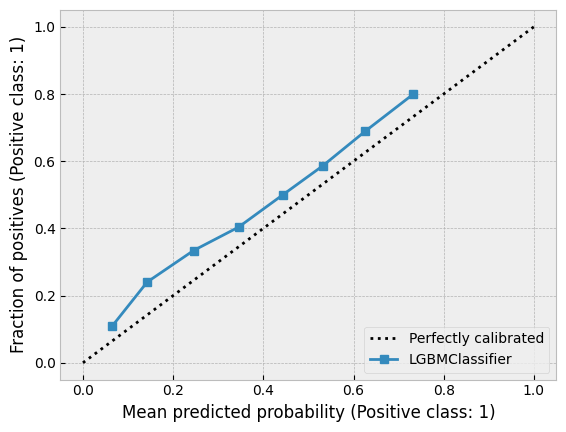

In [107]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(
        model_lgb,
        X_test,
        y_test,
        n_bins=10,
    )

## Benefit curve

Define a function for constant values

In [84]:
def benefit_plot(model, X_train, y_train, X_test, y_test):
                 
    plt.figure(figsize=(10,8))

    colors = ['olivedrab','deepskyblue',  'salmon']
    
    max_val = []
    for it, i in enumerate(['train', 'test']):
        
        if i == 'train':
            X = X_train
            y = y_train
            
        elif i == 'test':
            X = X_test
            y = y_test

        benefit = []    
        c_acceptance_rate = []
        
        y_hat = model.predict_proba(X)[:, 1]
        
        thr = np.linspace(0, 1, 50)
        
        for t in thr:
            #calculate confusion matrix
            pass
            #get TN, FN
            
            #calculate acceptance rate 
            pass
            
            #calculate the financial effect (use profit, loss, TN and FN)
            pass

        print('Model',i, 'Max Benefit: ', np.max(benefit)) 
        
        plt.plot(c_acceptance_rate, benefit, label = i, color = colors[it], linewidth=2)  
        plt.plot(c_acceptance_rate[np.argmax(benefit)], np.max(benefit), color = colors[it], marker='*', markersize=10)
         

    plt.xlabel('Acceptance rate')
    plt.ylabel('Benefit')
    plt.title('Benefit curve for old model')
    plt.legend(bbox_to_anchor=(1, 1));
    _ = plt.legend(loc= 0, prop= {'size': 16})

In [85]:
S = X['loan_amnt'].mean() # amount of loan
r = X['int_rate'].mean() / 100 # interest rate

lgd = 0.90 # losses in case of default

profit = r * S # profit if loan is returned
loss = lgd * S # loss if loan is gone

benefit_plot(model_lr, X_train, y_train, X_test, y_test)

ValueError: zero-size array to reduction operation maximum which has no identity

<Figure size 1000x800 with 0 Axes>

# Additional topics

## AutoML

- https://pycaret.org/guide/
- https://github.com/ray-project/tune-sklearn

Install packages

In [ ]:
# !pip install pycaret
# !pip install tune-sklearn ray[tune]

Do a setup

In [ ]:
import pycaret
from pycaret.classification import *

clf = setup(
    
    data=X.loc[idx_train, feature_columns + [target]].copy(),  
    test_data=X.loc[~idx_train, feature_columns + [target]].copy(),
    target=target,
    
    preprocess=False,
    
    fold_strategy='stratifiedkfold', 
    fold=5,
    
    session_id=123, 
    log_experiment=True, 
    experiment_name='juice1'
)

,Description,Value
0,session_id,123
1,Target,loan_status
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(138766, 69)"
5,Missing Values,False
6,Numeric Features,64
7,Categorical Features,4
8,Transformed Train Set,"(138766, 68)"
9,Transformed Test Set,"(197011, 68)"


Fit logistic regression

In [ ]:
lr = create_model(
    estimator='lr', 
    fold=4
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8372,0.6606,0.0146,0.2967,0.0279,0.0131,0.0333
1,0.8397,0.5906,0.0020,0.2391,0.0039,0.0013,0.0079
2,0.8359,0.6558,0.0202,0.2940,0.0379,0.0177,0.0387
3,0.8376,0.6636,0.0175,0.3322,0.0333,0.0176,0.0434
Mean,0.8376,0.6426,0.0136,0.2905,0.0257,0.0124,0.0308
SD,0.0014,0.0302,0.0070,0.0333,0.0131,0.0067,0.0137


In [ ]:
lr.C

1.0

Tune logistic regression

In [ ]:
tuned_lr = tune_model(
    estimator=lr, 
    optimize='AUC', 
    n_iter=10,
    search_library='tune-sklearn'
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6380,0.6858,0.6419,0.2515,0.3614,0.1714,0.2081
1,0.6412,0.6890,0.6365,0.2525,0.3615,0.1724,0.2081
2,0.6384,0.6785,0.6247,0.2484,0.3554,0.1647,0.1986
3,0.6432,0.6820,0.6261,0.2516,0.3590,0.1700,0.2040
4,0.6416,0.6946,0.6434,0.2540,0.3642,0.1756,0.2124
Mean,0.6405,0.6860,0.6345,0.2516,0.3603,0.1708,0.2062
SD,0.0020,0.0056,0.0078,0.0018,0.0029,0.0036,0.0047


In [ ]:
tuned_lr.C

5.56

Check and visualize performance 

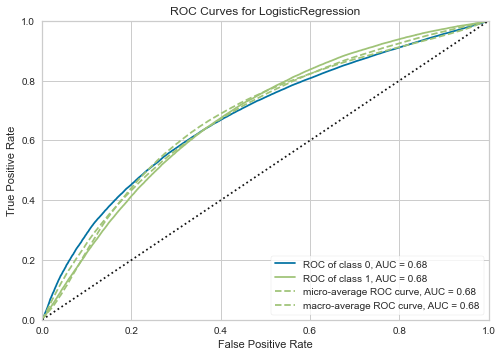

In [ ]:
plot_model(tuned_lr)

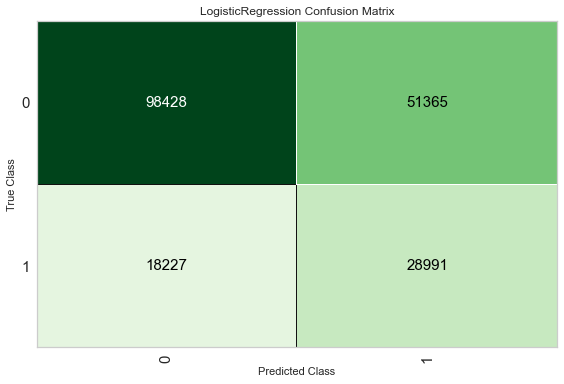

In [ ]:
plot_model(tuned_lr, plot = 'confusion_matrix')

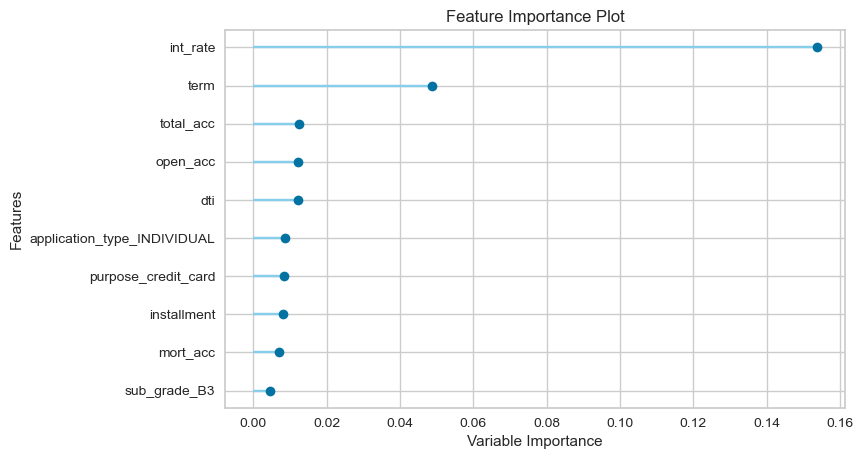

In [ ]:
plot_model(tuned_lr, plot = 'feature')

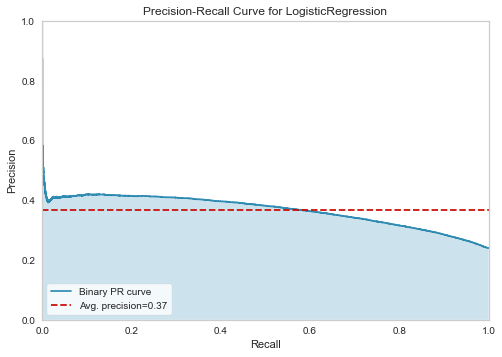

In [ ]:
plot_model(tuned_lr, plot = 'pr')

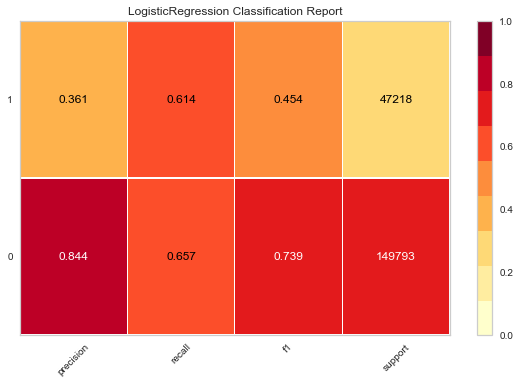

In [ ]:
plot_model(tuned_lr, plot = 'class_report')

Here you can try using some ensembles

In [ ]:
ensembled_models = compare_models(whitelist = models(type='ensemble').index.tolist(), fold = 3)

In [ ]:
blender = blend_models(estimator_list = [boosted_dt, bagged_dt, tuned_rf], method = 'soft')

In [ ]:
stacker = stack_models(estimator_list = [boosted_dt,bagged_dt,tuned_rf], meta_model=rf)

## More Interpretability

- Good overview: https://christophm.github.io/interpretable-ml-book/interpretability.html
- Nice library: https://github.com/csinva/imodels

In [ ]:
# !pip install imodels

In [ ]:
from imodels import RuleFitClassifier

model_rulefit = RuleFitClassifier(
    tree_size=4, 
    sample_fract='default', 
    max_rules=10, 
#     include_linear=True, 
    cv=3, 
    random_state=42
)

model_rulefit.fit(X_train, y_train)   # fit model

print(model_rulefit) # print the rule-based model

RuleFitClassifier(alphas=None, cv=3, exp_rand_tree_size=True,
                  include_linear=True, lin_standardise=True,
                  lin_trim_quantile=0.025, max_rules=10, memory_par=0.01,
                  random_state=42, sample_fract='default', tree_generator=None,
                  tree_size=4)


In [ ]:
model_rulefit.visualize()

,rule,coef
1,feature_1,-0.037


In [ ]:
model_rulefit.get_rules()

,rule,type,coef,support,importance
0,feature_0,linear,0.000000,1,0.000000
1,feature_1,linear,-0.037428,1,0.336762
2,feature_2,linear,0.000000,1,0.000000
3,feature_3,linear,0.000000,1,0.000000
4,feature_4,linear,0.000000,1,0.000000
...,...,...,...,...,...
63,feature_63,linear,0.000000,1,0.000000
64,feature_64,linear,0.000000,1,0.000000
65,feature_65,linear,0.000000,1,0.000000
66,feature_66,linear,0.000000,1,0.000000


In [ ]:
preds_proba = model.predict_proba(X_test) # predicted probabilities: shape is (n_test, n_classes)